# Connect 4 Dataset Generation
Generating dataset for training.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/Connect4_FAST'
os.makedirs(f'{PROJECT_DIR}/datasets', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/checkpoints', exist_ok=True)



Mounted at /content/drive


In [2]:
import numpy as np
import random
import pickle
import json
import time
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



In [3]:
class Connect4:
    """Connect4 Logic"""

    def __init__(self):
        self.board = np.zeros((6, 7), dtype=np.int8)
        self.heights = np.zeros(7, dtype=np.int8)  # Track column heights
        self.current_player = 1
        self.winner = None
        self.move_count = 0

    def copy(self):
        new = Connect4()
        new.board = self.board.copy()
        new.heights = self.heights.copy()
        new.current_player = self.current_player
        new.winner = self.winner
        new.move_count = self.move_count
        return new

    def legal_moves(self):
        return [c for c in range(7) if self.heights[c] < 6]

    def make_move(self, col):
        if self.heights[col] >= 6:
            return False

        row = self.heights[col]
        self.board[row, col] = self.current_player
        self.heights[col] += 1
        self.move_count += 1

        # Fast win check - only check around last move
        if self._check_win(row, col):
            self.winner = self.current_player
        elif self.move_count >= 42:
            self.winner = 0

        self.current_player *= -1
        return True

    def _check_win(self, row, col):
        """Numpy win check"""
        player = self.board[row, col]

        # Vertical (only check down)
        if row <= 2:
            if np.sum(self.board[row:row+4, col]) == 4 * player:
                return True

        # Horizontal
        for c in range(max(0, col-3), min(4, col+1)):
            if np.sum(self.board[row, c:c+4]) == 4 * player:
                return True

        # Diagonals
        for dr, dc in [(1, 1), (1, -1)]:
            count = 1
            # Check both directions
            for sign in [1, -1]:
                r, c = row + sign*dr, col + sign*dc
                while 0 <= r < 6 and 0 <= c < 7 and self.board[r, c] == player:
                    count += 1
                    r += sign*dr
                    c += sign*dc
            if count >= 4:
                return True

        return False

    def is_terminal(self):
        return self.winner is not None

    def get_result(self, player):
        if self.winner is None:
            return 0.0
        return 1.0 if self.winner == player else (-1.0 if self.winner != 0 else 0.0)

    def encode(self):
        """6x7x2 encoding for neural networks"""
        result = np.zeros((6, 7, 2), dtype=np.float32)
        result[:, :, 0] = (self.board == 1)
        result[:, :, 1] = (self.board == -1)
        return result



In [4]:
class FastMCTS:
    """Optimized MCTS with smart shortcuts"""

    # Opening book for instant first 2 moves
    OPENINGS = [3, 2, 4, 1, 5]  # Center-focused openings

    def __init__(self, simulations=150):
        self.sims = simulations

    def get_move(self, game):
        # Ultra-fast opening book (first 2 moves)
        if game.move_count == 0:
            return random.choice([3, 2, 4])  # Center preference
        if game.move_count == 1:
            return random.choice([3, 2, 4]) if 3 in game.legal_moves() else random.choice(game.legal_moves())

        # Instant win
        win = self._find_winning_move(game, game.current_player)
        if win is not None:
            return win

        # Instant block
        block = self._find_winning_move(game, -game.current_player)
        if block is not None:
            return block

        # Adaptive simulations based on game stage
        if game.move_count < 10:
            sims = 100  # Opening: fast
        elif game.move_count < 25:
            sims = 150  # Midgame: balanced
        else:
            sims = 250  # Endgame: careful

        return self._mcts(game, sims)

    def _find_winning_move(self, game, player):
        """Check if player can win immediately"""
        for col in game.legal_moves():
            test = game.copy()
            old_p = test.current_player
            test.current_player = player
            test.make_move(col)
            if test.winner == player:
                return col
            test.current_player = old_p
        return None

    def _mcts(self, game, sims):
        """Core MCTS with minimal overhead"""
        root_player = game.current_player
        stats = {}  # {board_hash: [visits, value_sum]}

        for _ in range(sims):
            node = game.copy()
            path = []

            # Selection + Expansion
            while not node.is_terminal():
                state = hash(node.board.tobytes())
                path.append(state)

                if state not in stats:
                    stats[state] = [0, 0.0]

                moves = node.legal_moves()
                if not moves:
                    break

                # UCB1 selection
                best_move = None
                best_ucb = -np.inf

                parent_visits = stats[state][0]

                for col in moves:
                    test = node.copy()
                    test.make_move(col)
                    child_hash = hash(test.board.tobytes())

                    if child_hash not in stats:
                        stats[child_hash] = [0, 0.0]

                    visits, value = stats[child_hash]

                    if visits == 0:
                        ucb = float('inf')
                    else:
                        exploit = value / visits
                        explore = 1.4 * np.sqrt(np.log(parent_visits + 1) / visits)
                        ucb = exploit + explore

                    if ucb > best_ucb:
                        best_ucb = ucb
                        best_move = col

                node.make_move(best_move)

                # Early rollout if new node
                if stats[hash(node.board.tobytes())][0] == 0:
                    path.append(hash(node.board.tobytes()))
                    break

            # Fast rollout (max 15 moves)
            rollout_depth = 0
            while not node.is_terminal() and rollout_depth < 15:
                moves = node.legal_moves()
                if not moves:
                    break
                node.make_move(random.choice(moves))
                rollout_depth += 1

            result = node.get_result(root_player)

            # Backpropagate
            for state in path:
                if state in stats:
                    stats[state][0] += 1
                    stats[state][1] += result

        # Choose best move
        best_move = None
        best_value = -np.inf

        for col in game.legal_moves():
            test = game.copy()
            test.make_move(col)
            state = hash(test.board.tobytes())

            if state in stats and stats[state][0] > 0:
                value = stats[state][1] / stats[state][0]
            else:
                value = -np.inf

            if value > best_value:
                best_value = value
                best_move = col

        return best_move if best_move is not None else random.choice(game.legal_moves())



In [5]:
def generate_dataset(num_games, random_prob=0.15, random_depth=12):
    """Generate dataset with progress tracking"""

    player = FastMCTS(simulations=150)

    all_boards = []
    all_moves = []

    stats = {'wins': 0, 'losses': 0, 'draws': 0, 'total_moves': 0}

    start_time = time.time()

    for game_num in tqdm(range(num_games), desc="Generating games"):
        game = Connect4()
        game_boards = []
        game_moves = []

        while not game.is_terminal():
            current_player = game.current_player

            # Random exploration in opening
            if game.move_count < random_depth and random.random() < random_prob:
                col = random.choice(game.legal_moves())
            else:
                col = player.get_move(game)

                # Store position (always from player 1 perspective)
                if current_player == 1:
                    board = game.encode()
                else:
                    flipped = game.copy()
                    flipped.board *= -1
                    board = flipped.encode()

                game_boards.append(board)
                game_moves.append(col)

            game.make_move(col)

            if game.move_count > 42:
                break

        # Track stats
        if game.winner == 1:
            stats['wins'] += 1
        elif game.winner == -1:
            stats['losses'] += 1
        else:
            stats['draws'] += 1

        stats['total_moves'] += len(game_boards)

        all_boards.extend(game_boards)
        all_moves.extend(game_moves)

        # Progress update every 500 games
        if (game_num + 1) % 500 == 0:
            elapsed = time.time() - start_time
            rate = (game_num + 1) / (elapsed / 60)
            eta = (num_games - game_num - 1) / rate if rate > 0 else 0
            print(f"\n  Games: {game_num+1}/{num_games} | Rate: {rate:.1f}/min | ETA: {eta:.0f}min | Examples: {len(all_boards):,}")

    elapsed = time.time() - start_time

    print(f"\n{'='*60}")
    print(f"{'='*60}")
    print(f"Games: {num_games:,}")
    print(f"Examples: {len(all_boards):,}")
    print(f"Time: {elapsed/60:.1f} minutes ({elapsed/3600:.2f} hours)")
    print(f"Rate: {num_games/(elapsed/60):.1f} games/min")
    print(f"\nGame outcomes:")
    print(f"P1 wins: {stats['wins']} ({stats['wins']/num_games*100:.1f}%)")
    print(f"  P2 wins: {stats['losses']} ({stats['losses']/num_games*100:.1f}%)")
    print(f"  Draws: {stats['draws']} ({stats['draws']/num_games*100:.1f}%)")
    print(f"  Avg moves/game: {stats['total_moves']/num_games:.1f}")

    return np.array(all_boards), np.array(all_moves), stats



In [6]:
# Configuration for 2-3 hour session
NUM_GAMES = 5000  # Target: 100k examples
RANDOM_PROB = 0.15
RANDOM_DEPTH = 12

print(f"Target: {NUM_GAMES:,} games in 2-3 hours\n")

X, y, stats = generate_dataset(
    num_games=NUM_GAMES,
    random_prob=RANDOM_PROB,
    random_depth=RANDOM_DEPTH
)

print(f"\n Dataset ready!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Target: 5,000 games in 2-3 hours



Generating games:   0%|          | 0/5000 [00:00<?, ?it/s]


  Games: 500/5000 | Rate: 48.9/min | ETA: 92min | Examples: 12,734

  Games: 1000/5000 | Rate: 47.7/min | ETA: 84min | Examples: 25,978

  Games: 1500/5000 | Rate: 48.4/min | ETA: 72min | Examples: 38,421

  Games: 2000/5000 | Rate: 48.9/min | ETA: 61min | Examples: 50,892

  Games: 2500/5000 | Rate: 48.7/min | ETA: 51min | Examples: 63,896

  Games: 3000/5000 | Rate: 48.9/min | ETA: 41min | Examples: 76,511

  Games: 3500/5000 | Rate: 49.0/min | ETA: 31min | Examples: 89,073

  Games: 4000/5000 | Rate: 48.8/min | ETA: 20min | Examples: 102,119

  Games: 4500/5000 | Rate: 49.1/min | ETA: 10min | Examples: 114,308

  Games: 5000/5000 | Rate: 49.0/min | ETA: 0min | Examples: 127,115

Games: 5,000
Examples: 127,115
Time: 102.1 minutes (1.70 hours)
Rate: 49.0 games/min

Game outcomes:
P1 wins: 2415 (48.3%)
  P2 wins: 2008 (40.2%)
  Draws: 577 (11.5%)
  Avg moves/game: 25.4

✅ Dataset ready!
X shape: (127115, 6, 7, 2)
y shape: (127115,)


In [7]:
print("Augmenting with horizontal flips...")

X_aug = []
y_aug = []

for board, move in tqdm(zip(X, y), total=len(X), desc="Augmenting"):
    # Original
    X_aug.append(board)
    y_aug.append(move)

    # Flipped
    X_aug.append(np.flip(board, axis=1))
    y_aug.append(6 - move)

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

print(f"Original: {len(X):,} examples")
print(f"Augmented: {len(X_aug):,} examples")

Augmenting with horizontal flips...


Augmenting:   0%|          | 0/127115 [00:00<?, ?it/s]

Original: 127,115 examples
Augmented: 254,230 examples


Dataset Quality Analysis:
Total examples: 254,230
Shape: (254230, 6, 7, 2)

Move distribution:
  Column 0: 28,356 (11.2%)
  Column 1: 34,277 (13.5%)
  Column 2: 41,715 (16.4%)
  Column 3: 45,534 (17.9%)
  Column 4: 41,715 (16.4%)
  Column 5: 34,277 (13.5%)
  Column 6: 28,356 (11.2%)


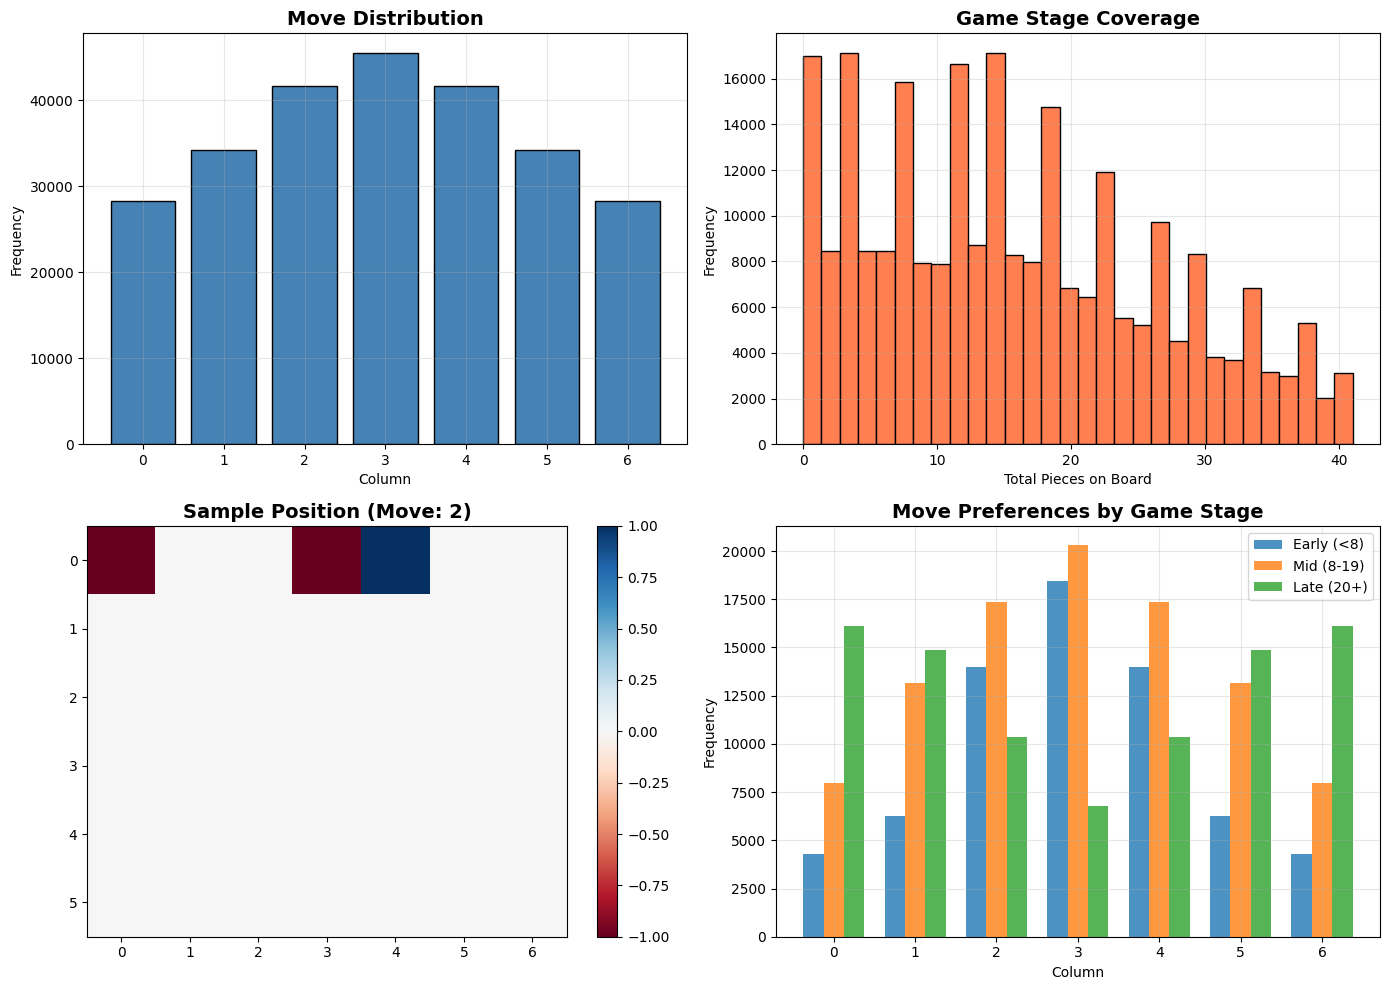

In [8]:
# Statistics
print("Dataset Quality Analysis:")
print(f"Total examples: {len(X_aug):,}")
print(f"Shape: {X_aug.shape}")
print(f"\nMove distribution:")

for col in range(7):
    count = np.sum(y_aug == col)
    pct = count / len(y_aug) * 100
    print(f"  Column {col}: {count:,} ({pct:.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Move distribution
axes[0, 0].bar(range(7), np.bincount(y_aug), color='steelblue', edgecolor='black')
axes[0, 0].set_title('Move Distribution', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Game stage coverage
piece_counts = [np.sum(board) for board in X_aug]
axes[0, 1].hist(piece_counts, bins=30, color='coral', edgecolor='black')
axes[0, 1].set_title('Game Stage Coverage', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Total Pieces on Board')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Sample board
idx = random.randint(0, len(X_aug) - 1)
sample = X_aug[idx]
board_viz = sample[:, :, 0] - sample[:, :, 1]
im = axes[1, 0].imshow(board_viz, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 0].set_title(f'Sample Position (Move: {y_aug[idx]})', fontweight='bold', fontsize=14)
plt.colorbar(im, ax=axes[1, 0])

# Moves by game stage
early = [y_aug[i] for i in range(len(y_aug)) if piece_counts[i] < 8]
mid = [y_aug[i] for i in range(len(y_aug)) if 8 <= piece_counts[i] < 20]
late = [y_aug[i] for i in range(len(y_aug)) if piece_counts[i] >= 20]

x_pos = np.arange(7)
width = 0.25
axes[1, 1].bar(x_pos - width, np.bincount(early, minlength=7), width, label='Early (<8)', alpha=0.8)
axes[1, 1].bar(x_pos, np.bincount(mid, minlength=7), width, label='Mid (8-19)', alpha=0.8)
axes[1, 1].bar(x_pos + width, np.bincount(late, minlength=7), width, label='Late (20+)', alpha=0.8)
axes[1, 1].set_title('Move Preferences by Game Stage', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PROJECT_DIR}/dataset_quality.png', dpi=150, bbox_inches='tight')
plt.show()



In [9]:
# Save complete dataset
dataset = {
    'X_train': X_aug,
    'y_train': y_aug,
    'X_original': X,
    'y_original': y,
    'metadata': {
        'num_games': NUM_GAMES,
        'examples_original': len(X),
        'examples_augmented': len(X_aug),
        'mcts_simulations': '100-250 (adaptive)',
        'random_prob': RANDOM_PROB,
        'random_depth': RANDOM_DEPTH,
        'encoding': '6x7x2',
        'augmentation': 'horizontal_flip',
        'generation_stats': stats,
        'created': datetime.now().isoformat()
    }
}

# Save pickle
pkl_path = f'{PROJECT_DIR}/datasets/connect4_fast_{NUM_GAMES}.pkl'
with open(pkl_path, 'wb') as f:
    pickle.dump(dataset, f)

# Save compressed numpy
npz_path = f'{PROJECT_DIR}/datasets/connect4_fast_{NUM_GAMES}.npz'
np.savez_compressed(
    npz_path,
    X_train=X_aug,
    y_train=y_aug
)

# Save metadata JSON
json_path = f'{PROJECT_DIR}/datasets/metadata.json'
with open(json_path, 'w') as f:
    json.dump(dataset['metadata'], f, indent=2, default=str)



In [10]:
# Test loading
print("Testing dataset loading...")

data = np.load(npz_path)
X_loaded = data['X_train']
y_loaded = data['y_train']

print(f"X shape: {X_loaded.shape}")
print(f"y shape: {y_loaded.shape}")
print(f"  data = np.load('{npz_path}')")
print(f"  X_train = data['X_train']")
print(f"  y_train = data['y_train']")

Testing dataset loading...
X shape: (254230, 6, 7, 2)
y shape: (254230,)
  data = np.load('/content/drive/MyDrive/Connect4_FAST/datasets/connect4_fast_5000.npz')
  X_train = data['X_train']
  y_train = data['y_train']
